# Complex networks project: shared subscribers and subscriptions networks on Youtube

Youtube has become in a few years the most famous internet platform to share videos. Created at the beginning to share personal videos with others, Youtube is now an important actor of the entertainment industry. Youtubers, Youtube users who regularly post videos, are able to gather millions of subscribers on their videos (PewDiePie recently crossed the 100 million subscribers barrier). 

I wanted to explore some features of Youtube network structure as I believe Youtube is not a social network (even if Youtube is adding features to make it more social).



ADVISE: do not do an all run!

## Packages

In [117]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import community #package for Louvain detection community
import pickle

from tqdm.notebook import tqdm

## Data

The complete dataset focuses on 15088 active Youtube users (out of more than 800000 users) and includes 5 different types of edges: 1- the contact network between these users; 2- the number of shared friends among all Youtube users for whom they had data excluding the active ones; 3- the number of shared subscriptions; 4- the number of shared subscribers; 5- the number of shared favorite videos.

As one may have guessed, those data were mainly used to test new techniques of community detection using 5 dimensions. [1] 


From my personal use, "contact" feature is not important nowadays in Youtube (I can't even find where are my contacts or how to add one on Youtube). The meaning of "shared favorite videos" is ambiguous as favorite video could mean a video added to one's personal default "Favorite" video folder or liked videos. In any case, I believe the majority of users do not use that feature as importantly as subscribing to a channel. Hence, the work below will only focus on the edges 3- (\~ 5 million edges) and 4- (\~ 2 million edges). 

Source: http://socialcomputing.asu.edu/datasets/YouTube

In [1]:
path = ''

In [45]:
## Computing the number of nodes

with open(path + 'nodes.csv', mode = 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    n = sum(1 for row in reader)

In [37]:
## Import edges data

datalist = ['contact','shared friends', 'subscription', 'subscriber', 'video']

for i in [3,4]:
    vars()['edges{}'.format(i)] = []
    with open(path + '{}-edges.csv'.format(i), mode ='r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        reader = list(reader)
        for row in reader:
        # conversion en int + add data type 
            rowadd = [int(i) for i in row[:2]] + [{datalist[i-1]: int(row[-1])}]
            vars()['edges{}'.format(i)].append(rowadd)

## The Graph

I denote G3 the graph with the edges 3- and G4 the graph with the edges 4-. 

In [48]:
## Initialize the graphs

G3 = nx.Graph()
G3.add_nodes_from(np.arange(1,n+1,1))
G3.add_edges_from(edges3)

G4 = nx.Graph()
G4.add_nodes_from(np.arange(1,n+1,1))
G4.add_edges_from(edges4)

If one wants to skip previous steps, it is possible to load unworked version of G3 and G4. However I had G3 and G4 created faster by loading the csv files.

In [35]:
## Skip creating the data by directly importing the graphs

G3 = nx.read_gexf(path + 'G3_raw.gexf', node_type = int)
G4 = nx.read_gexf(path + 'G4_raw.gexf', node_type = int)

A short overview of the data to get a hang of the data structure.

In [49]:
## Number of edges
print(len(G3.nodes()))
print(len(G4.nodes()))

15088
15088


In [95]:
## Data overview

compteur = 0
for u,v,attr in G3.edges(data = True):
    compteur += 1
    if compteur < 10:
        print(u,v,attr)
    else:
        break    

compteur = 0
for u,v,attr in G4.edges(data = True):
    compteur += 1
    if compteur < 10:
        print(u,v,attr)
    else:
        break

1 811 {'subscription': 1}
1 813 {'subscription': 1}
1 814 {'subscription': 1}
1 815 {'subscription': 1}
1 816 {'subscription': 1}
1 817 {'subscription': 1}
1 818 {'subscription': 1}
1 820 {'subscription': 1}
1 821 {'subscription': 1}
4 14437 {'subscriber': 1}
8 329 {'subscriber': 1}
8 644 {'subscriber': 1}
8 3121 {'subscriber': 1}
8 3956 {'subscriber': 1}
8 5088 {'subscriber': 1}
8 5089 {'subscriber': 1}
8 5090 {'subscriber': 1}
8 5091 {'subscriber': 1}


In [ ]:
## Save the graph if needed

nx.readwrite.gexf.write_gexf(G4, path + 'G4.gexf')

## Degree distribution analysis

A first thing one can compute is the weighted degree distribution throughout the graph. Both graph can't be (at least easily) approximated by a power law. It may not seem obvious but one can uncomment some lines in the code, tweak the power parameter and will notice no clear fit. The steep in log/log plot is not obvious and tweaking the number of bins in histogram may change the curve shape a lot.

A consequence is that Youtube, at least on the subscribers/subscriptions point of view, does not behave as a social network. 

Weirdly enough, if one computes the distribution of edges values, one will get that both graph follows a power law like distribution with a power coefficient \~ -2. 

In [180]:
## Calcul du degré de chaque noeud de G3
list_degree = [0 for node in G3.nodes()]
for u,v in G3.edges():
    value = G3.edges[u,v]['subscription']
    list_degree[u-1] += value/2
    list_degree[v-1] += value/2

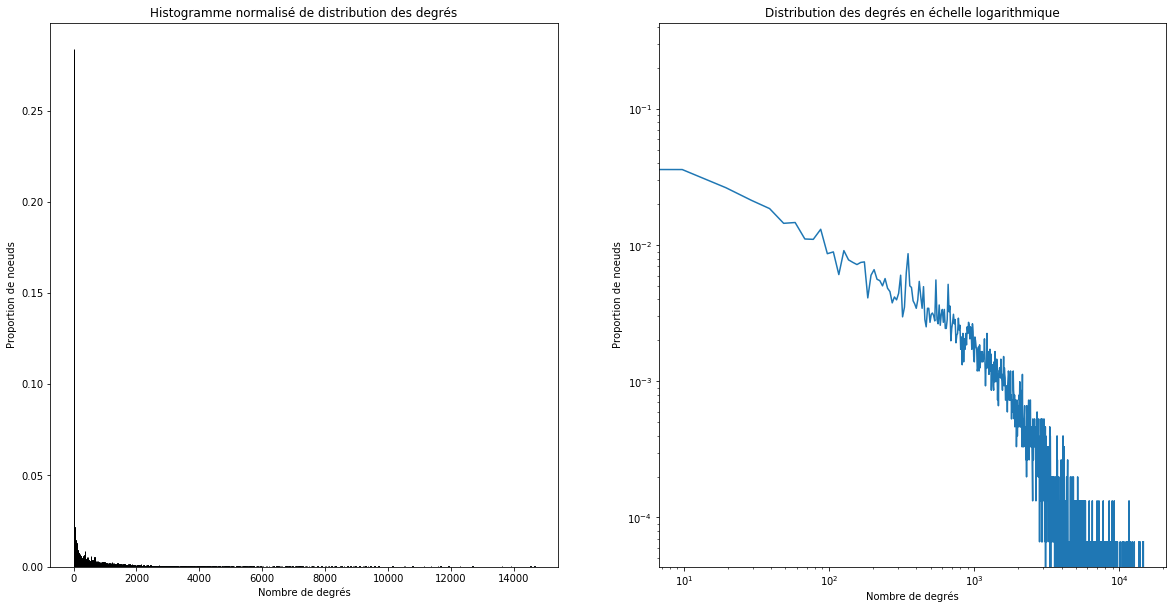

In [181]:
## Degree distribution of G3

n = len(G3.nodes())
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

lowcut = 0
power = 2

histo_sub, bins = np.histogram(list_degree, bins = n//10)
ax1.bar(list(bins)[lowcut:-1], list(histo_sub/np.sum(histo_sub))[lowcut:], width=np.diff(bins[lowcut:]), ec="k", align="edge")
#ax1.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax1.set_title('Histogramme normalisé de distribution des degrés')
ax1.set_xlabel('Nombre de degrés')
ax1.set_ylabel('Proportion de noeuds')
#ax1.set_xlim(0,5000)
#ax1.set_ylim(0,0.1)

ax2.plot(bins[:-1],list(histo_sub/np.sum(histo_sub))[lowcut:])
#ax2.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax2.set_title('Distribution des degrés en échelle logarithmique')
ax2.set_xlabel('Nombre de degrés')
ax2.set_ylabel('Proportion de noeuds')
plt.yscale('log')
plt.xscale('log')

plt.show()

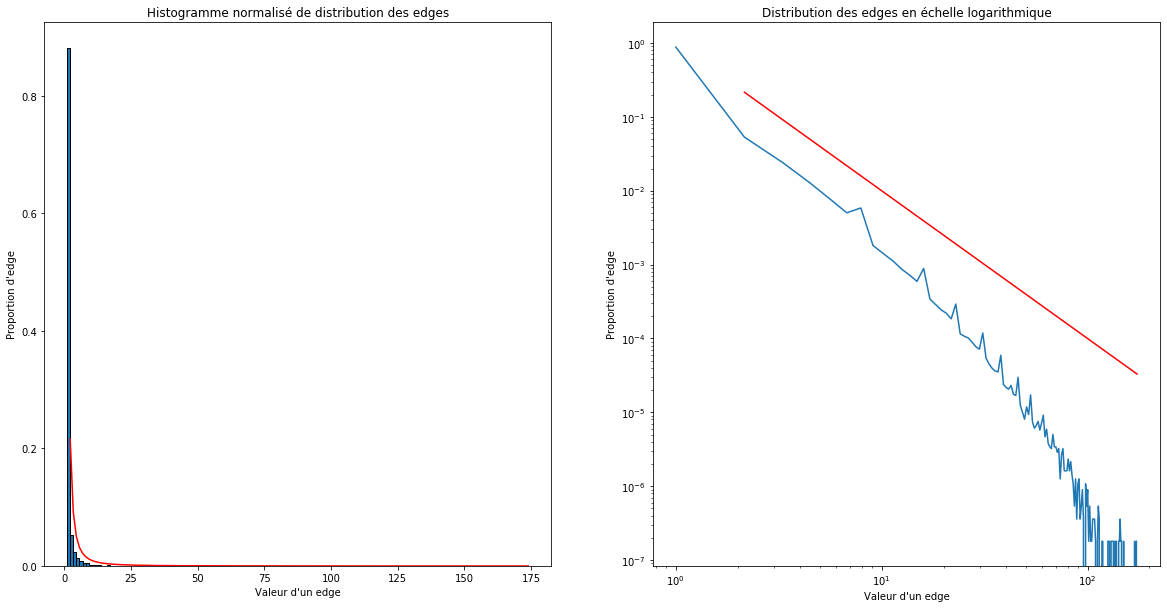

In [187]:
## Edge distribution of G3

n = len(G3.nodes())
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

lowcut = 0
power = 2

list_attr = [G3.edges[u,v]['subscription'] for u,v in G3.edges()]
histo_sub, bins = np.histogram(list_attr, bins = n//100)
ax1.bar(list(bins)[lowcut:-1], list(histo_sub/np.sum(histo_sub))[lowcut:], width=np.diff(bins[lowcut:]), ec="k", align="edge")
ax1.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax1.set_title('Histogramme normalisé de distribution des edges')
ax1.set_xlabel('Valeur d\'un edge')
ax1.set_ylabel('Proportion d\'edge')

ax2.plot(bins[:-1],list(histo_sub/np.sum(histo_sub))[lowcut:])
ax2.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax2.set_title('Distribution des edges en échelle logarithmique')
ax2.set_xlabel('Valeur d\'un edge')
ax2.set_ylabel('Proportion d\'edge')
plt.yscale('log')
plt.xscale('log')

plt.show()

In [182]:
## Calcul du degré de chaque noeud de G4

list_degree = [0 for node in G4.nodes()]
for u,v in G4.edges():
    value = G4.edges[u,v]['subscriber']
    list_degree[u-1] += value/2
    list_degree[v-1] += value/2

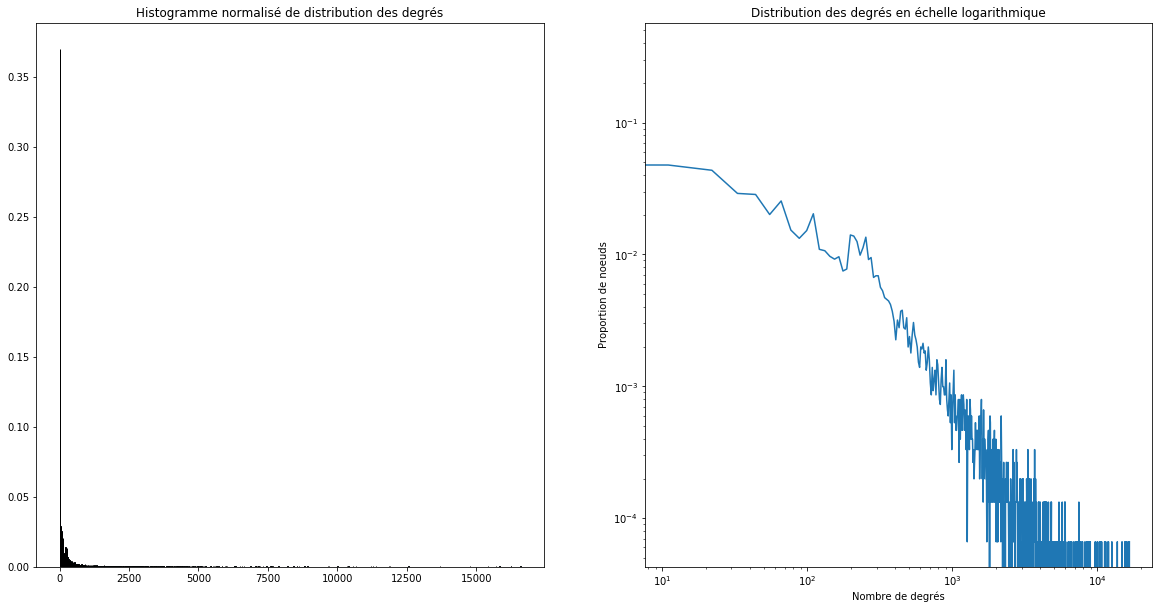

In [184]:
## Degree distribution of G4

n = len(G4.nodes())
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

lowcut = 0
power = 2
    
histo_sub, bins = np.histogram(list_degree, bins = n//10)
ax1.bar(list(bins)[lowcut:-1], list(histo_sub/np.sum(histo_sub))[lowcut:], width=np.diff(bins[lowcut:]), ec="k", align="edge")
#ax1.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax1.set_title('Histogramme normalisé de distribution des degrés')
ax2.set_xlabel('Nombre de degrés')
ax2.set_ylabel('Proportion de noeuds')
#ax1.set_xlim(0,5000)
#ax1.set_ylim(0,0.1)

ax2.plot(bins[:-1],list(histo_sub/np.sum(histo_sub))[lowcut:])
#ax2.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax2.set_title('Distribution des degrés en échelle logarithmique')
ax2.set_xlabel('Nombre de degrés')
ax2.set_ylabel('Proportion de noeuds')
plt.yscale('log')
plt.xscale('log')

plt.show()

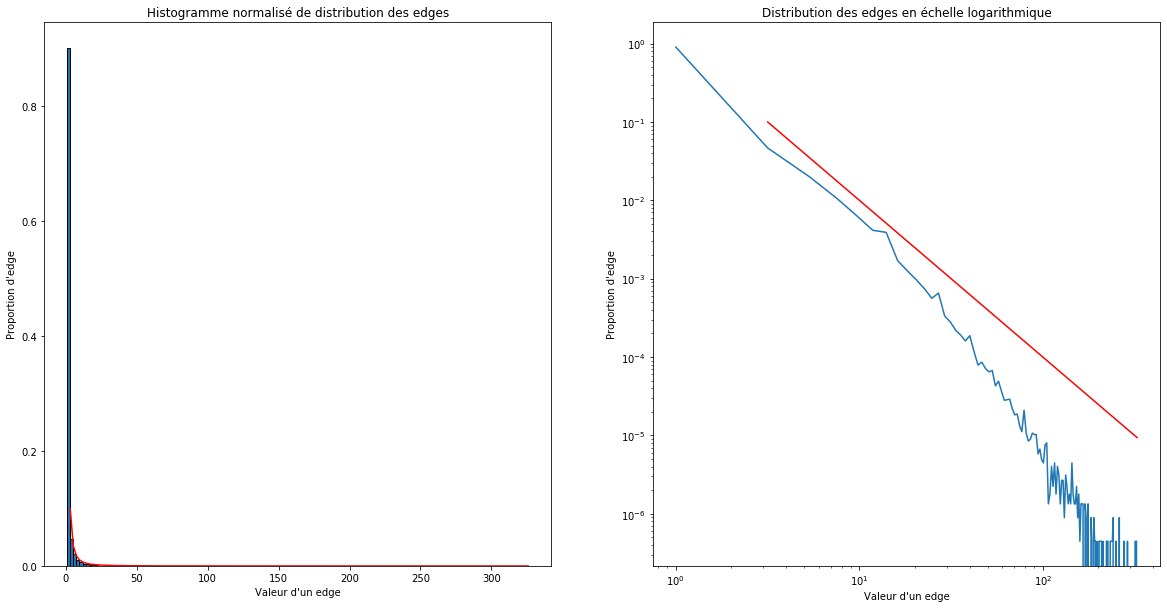

In [186]:
## Edge distribution of G4

n = len(G4.nodes())
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

lowcut = 0
power = 2

list_attr = [G4.edges[u,v]['subscriber'] for u,v in G4.edges()]
histo_sub, bins = np.histogram(list_attr, bins = n//100)
ax1.bar(list(bins)[lowcut:-1], list(histo_sub/np.sum(histo_sub))[lowcut:], width=np.diff(bins[lowcut:]), ec="k", align="edge")
ax1.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax1.set_title('Histogramme normalisé de distribution des edges')
ax1.set_xlabel('Valeur d\'un edge')
ax1.set_ylabel('Proportion d\'edge')

ax2.plot(bins[:-1],list(histo_sub/np.sum(histo_sub))[lowcut:])
ax2.plot(list(bins)[lowcut+1:],[1/i**power for i in list(bins)[lowcut+1:]],'r')
ax2.set_title('Distribution des edges en échelle logarithmique')
ax2.set_xlabel('Valeur d\'un edge')
ax2.set_ylabel('Proportion d\'edge')
plt.yscale('log')
plt.xscale('log')

plt.show()

## Comunity detection (Louvain)

Let us investigate communities in G3 and G4 using a Louvain algorithm provided by the package community. Computations can take a feeeeew minutes.

In [63]:
## Find communities with Louvain algorithms in G3

G3_louvain = community.best_partition(G3, weight = 'subscription')

In [71]:
## Find communities with Louvain algorithms in G4

G4_louvain = community.best_partition(G4, weight = 'subscriber')

The algorithm returns a dictionary with nodes as entries and stores a number for each node, the number of the community the node is associated with.

In [74]:
print(type(G3_louvain))
G4_louvain

<class 'dict'>


{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 3,
 10: 7,
 11: 8,
 12: 3,
 13: 3,
 14: 9,
 15: 10,
 16: 11,
 17: 12,
 18: 13,
 19: 14,
 20: 15,
 21: 3,
 22: 16,
 23: 17,
 24: 3,
 25: 3,
 26: 3,
 27: 3,
 28: 3,
 29: 18,
 30: 3,
 31: 3,
 32: 3,
 33: 3,
 34: 3,
 35: 3,
 36: 3,
 37: 19,
 38: 20,
 39: 21,
 40: 12,
 41: 12,
 42: 12,
 43: 12,
 44: 3,
 45: 22,
 46: 12,
 47: 3,
 48: 12,
 49: 23,
 50: 3,
 51: 3,
 52: 24,
 53: 12,
 54: 25,
 55: 3,
 56: 12,
 57: 26,
 58: 12,
 59: 12,
 60: 3,
 61: 27,
 62: 12,
 63: 12,
 64: 3,
 65: 28,
 66: 3,
 67: 12,
 68: 29,
 69: 3,
 70: 25,
 71: 25,
 72: 12,
 73: 3,
 74: 30,
 75: 3,
 76: 31,
 77: 3,
 78: 32,
 79: 3,
 80: 3,
 81: 3,
 82: 3,
 83: 27,
 84: 33,
 85: 3,
 86: 7,
 87: 3,
 88: 7,
 89: 3,
 90: 34,
 91: 7,
 92: 7,
 93: 7,
 94: 7,
 95: 7,
 96: 35,
 97: 7,
 98: 3,
 99: 36,
 100: 37,
 101: 37,
 102: 37,
 103: 11,
 104: 3,
 105: 11,
 106: 37,
 107: 36,
 108: 36,
 109: 37,
 110: 36,
 111: 37,
 112: 37,
 113: 36,
 114: 11,
 115: 36,
 116: 37,
 117

I provide saved computations of the Louvain algorithms as communities might differ from one run to another one. Following analysis should still be relevant even with different communities.

In [75]:
## Load the communities

with open (path + 'G_louvain.p', 'rb') as pfile:
    G3_louvain, G4_louvain = pickle.load(pfile)

A code to save the computations results.

In [73]:
## Save the communities as another run would give slightly different communities

with open (path + 'G_louvain.p','wb') as pfile:
    pickle.dump([G3_louvain, G4_louvain], pfile)

Create versions of G3 and G4 grouping nodes as communities detected previously.

In [85]:
## Community graph for G3

nb_com = G3_louvain[max(G3_louvain, key = G3_louvain.get)]
G3_community = nx.Graph()
G3_community.clear()
G3_community.add_nodes_from(np.arange(0,nb_com+1,1))

# Compute the weight of a community as the number of nodes inside and update 
node_weight_list = [0 for i in range (nb_com + 1)]
for node in G3_louvain:
    node_weight_list[G3_louvain[node]] += 1

for i in range(len(node_weight_list)):
    G3_community.add_node(i, node_weight = node_weight_list[i])
    
# Compute the edges between the communities considering 'subscription' as a weight
G3_community.remove_edges_from(G3_community.edges())
for u,v in G3.edges():
    weight = G3.edges[u,v]['subscription']
    u_com = G3_louvain[u]; v_com = G3_louvain[v]
    
    if (u_com, v_com) not in G3_community.edges():
        G3_community.add_edge(u_com,v_com, weight = weight)
    else:
        G3_community.edges[u_com,v_com]['weight'] += weight

In [101]:
## Data structure
print(len(G3_community.nodes()))
print(G3_community.nodes[0])

3336
{'node_weight': 4533, 'label': '0'}


Beware, there are more than 3000 communities but in reality, most of them are only involving one node. It is to say those nodes might be almost disconnected from the others in bigger comuunities. It means that on 15088 nodes, around 3000 can't be given to a community with current data. It may be interpreted as those nodes correspond to active users who either do not subscribe and so do not 'announce' their community affiliation either that in the 800000 users, the user 'true' community is not well enough represented. The communities found in G3 are communities of users who share interests in the same Youtubers.

In [111]:
print('Number of communities with only 1 node:', len([G3_community.nodes[i]['node_weight'] for i in G3_community.nodes if G3_community.nodes[i]['node_weight']==1]))
print('Number of communities with more than 1 node:',len([G3_community.nodes[i]['node_weight'] for i in G3_community.nodes if G3_community.nodes[i]['node_weight']>1]))
print('Number of communities with more than 10 node:',len([G3_community.nodes[i]['node_weight'] for i in G3_community.nodes if G3_community.nodes[i]['node_weight']>10]))

Number of communities with only 1 node: 3323
Number of communities with more than 1 node: 13
Number of communities with more than 10 node: 5


In [86]:
## Save for gephi use
nx.readwrite.write_gexf(G3_community, path + 'G3_community.gexf')

In [87]:
## Load
G3_community = nx.read_gexf(path + 'G3_community.gexf', node_type = int)

In [88]:
## Community graph for G4

nb_com = G4_louvain[max(G4_louvain, key = G4_louvain.get)]
G4_community = nx.Graph()
G4_community.clear()
G4_community.add_nodes_from(np.arange(0,nb_com+1,1))

# Compute the weight of a community as the number of nodes inside and update 
node_weight_list = [0 for i in range (nb_com + 1)]
for node in G4_louvain:
    node_weight_list[G4_louvain[node]] += 1

for i in range(len(node_weight_list)):
    G4_community.add_node(i, node_weight = node_weight_list[i])
    
# Compute the edges between the communities considering 'subscriber' as a weight
G4_community.remove_edges_from(G4_community.edges())
for u,v in G4.edges():
    weight = G4.edges[u,v]['subscriber']
    u_com = G4_louvain[u]; v_com = G4_louvain[v]
    
    if (u_com, v_com) not in G4_community.edges():
        G4_community.add_edge(u_com,v_com,weight = weight)
    else:
        G4_community.edges[u_com,v_com]['weight'] += weight

In [115]:
## Data structure
print(len(G4_community.nodes()))
print(G4_community.nodes[0])

4648
{'node_weight': 1, 'label': '0'}


G4 communities have the same behaviors as G3 communities: lots of communities are isolated nodes. Recall that 4-edges gives the number of shared subscribers.  This time, those isolated nodes can be interpreted as non Youtuber user: someone who does not actively post videos on his/her channel will not get any subscribers and so will have really low number of shared subscribers. So the communities show communities of Youtubers for G4.

In [114]:
print('Number of communities with only 1 node:', len([G4_community.nodes[i]['node_weight'] for i in G4_community.nodes if G4_community.nodes[i]['node_weight']==1]))
print('Number of communities with more than 1 node:',len([G4_community.nodes[i]['node_weight'] for i in G4_community.nodes if G4_community.nodes[i]['node_weight']>1]))
print('Number of communities with more than 10 node:',len([G4_community.nodes[i]['node_weight'] for i in G4_community.nodes if G4_community.nodes[i]['node_weight']>10]))

Number of communities with only 1 node: 4633
Number of communities with more than 1 node: 15
Number of communities with more than 10 node: 10


One may notice that there are not the same numbers of communities from users' point of view (G3) and Youtuberss one (G4). It is not that weird: Youtuber's communities describe the content communities whereas users' communities describe different kind of user (there might be a community of users who watch gaming and technologies related content whereas another community might watch technologies and scientific contents). So it might be interesting to look at relations between communities for G3.

In [89]:
## Save for gephi use
nx.readwrite.write_gexf(G4_community, path + 'G4_community.gexf')

In [90]:
## Load
G4_community = nx.read_gexf(path + 'G4_community.gexf', node_type = int)

#### G3 Community network
The subgraph of important communities is connected.

![title](G3_commu.png)

#### G4 community network
The subgraph of important communities is connected.

![G4 community](G4_commu.png)

Let us update the master graphs G3 and G4 so we can identify the communities. If one wants to save the updated graphs and explore them in Gephi, beware that save (and load) time are quite long and Gephi 64bit with extended data storage can show all the nodes and edges but will be really slow.

In [91]:
## Update G3 to add community number to each node

for node in G3.nodes():
    community_nb = G3_louvain[node]
    G3.nodes[node]['community'] = community_nb

In [94]:
## Data structure
G3.nodes[1]

{'community': 0}

In [96]:
## Save
nx.readwrite.write_gexf(G3, path + 'G3.gexf')

In [ ]:
## Load
G3 = nx.read_gexf(path + 'G3.gexf', node_type = int)

In [97]:
## Update for G4 to add community number to each node

for node in G4.nodes():
    community_nb = G4_louvain[node]
    G4.nodes[node]['community'] = community_nb

In [98]:
## Data structure 
G4.nodes[234]

{'community': 3}

In [99]:
## Save
nx.readwrite.write_gexf(G4, path + 'G4.gexf')

In [ ]:
## Load
G4 = nx.read_gexf(path + 'G4.gexf', node_type = int)

#### G4 network
The colors show the different important communities. Spatialization was done with a few runs (and only a few) of ForceAtlas2. The main goal of the image is only to verify that communities visually correpond to what ForceAtlas2 would spatially create as communities.

The vizualization was not done with G3 because there are too much data for my computer to handle...

![title](G4.png)


## Subgraphs of communities

One might want to investigate properties on communities of Youtube. So here is a code creating a subgraph for each communities in G3 and G4. Some communities have only a few nodes so I set an arbitrary condition that a community must have more than 10 nodes to be considered as a community. Running time can be long... The tqdm package helps see at which iteration the loop is at (the estimated computational time is false as computational time changes at each iteration). I had in all around 10 min of computations for G3 communities and 8 min for G4 communities.

In [148]:
## Create for each community its list of nodes

nb_com = G3_louvain[max(G3_louvain, key = G3_louvain.get)]
list_nodes_in_com = [[] for i in range (nb_com+1)]
for i in range(1,len(G3_louvain)+1):
    community_nb = G3_louvain[i]
    list_nodes_in_com[community_nb].append(i)


## For each community, create its graph and add it to a list
list_graph_com3 = []
for community_nb in tqdm(range(len(list_nodes_in_com))):
    list_nodes_in_com_i = list_nodes_in_com[community_nb]
    if len(list_nodes_in_com_i) > 10:
        graph = nx.Graph()
        graph.clear()
        graph.add_nodes_from(list_nodes_in_com_i)
        graph.add_edges_from( [[u,v,{'subscription':G3.edges[u,v]['subscription']}] for u,v in G3.edges() if u and v in list_nodes_in_com_i])
        list_graph_com3.append(graph)

In [151]:
## Save
with open (path + 'list_graph_com3.p','wb') as pfile:
    pickle.dump(list_graph_com3, pfile)

In [152]:
## Load
with open (path + 'list_graph_com3.p', 'rb') as pfile:
    list_graph_com3 = pickle.load(pfile)

If one computes the average and root mean square degrees inside each community, one gets values of root mean square degrees higher than the mean degree. So like the degree distribution of G3 and G4 we saw earlier, communities have also lots of low degrees nodes and a few large ones.

In [226]:
## Average weighted degree and root mean square degree for all G3 communities

# Compute the average degree for each node in each community
degree_com3 = [graph.degree(weight = 'subscription') for graph in list_graph_com3]
degree_com3 = np.asarray(degree_com3)

# Compute the average neighbor degree for each community
degree_com3_average = [np.average([ graph_degree[key] for key in sorted(dict(graph_degree).keys())]) for graph_degree in degree_com3 ]
degree_com3_average = np.asarray(degree_com3_average)

# Compute the root mean square degree for each community
degree_com3_ms = [np.average([ graph_degree[key]**2 for key in sorted(dict(graph_degree).keys())]) for graph_degree in degree_com3]
degree_com3_ms = np.asarray(degree_com3_ms)
degree_com3_rms = [ np.sqrt(np.absolute( degree_com3_ms[i] - degree_com3_average[i]*degree_com3_average[i] )) for i in range(len(degree_com3_ms)) ]

print(degree_com3_average, '\n', degree_com3_rms)

[547.72626972 386.79992264  97.81378784  78.15690062 782.51671733] 
 [999.4415681702117, 880.5106179738866, 471.86529265435274, 263.5905274336434, 2101.477879327142]


Let us focus on 1 node with high degree and let us check if it is big value edges or rather many small edges.

In [225]:
Degree_w = list_graph_com3[0].degree(weight = 'subscription')
Degree = list_graph_com3[0].degree(weight = None)
print('Weighted degree of node 278:', Degree_w[278])
print('Unweighted degree of node 278:', Degree[278])

Weighted degree of node 278: 4360
Unweighted degree of node 278: 2389


Doing the same thing for G4.

In [142]:
# Create for each community its list of nodes

nb_com = G4_louvain[max(G4_louvain, key = G4_louvain.get)]
list_nodes_in_com = [[] for i in range (nb_com+1)]
for i in range(1,len(G4_louvain)+1):
    community_nb = G4_louvain[i]
    list_nodes_in_com[community_nb].append(i)

# For each community, create its graph
list_graph_com4 = []
for community_nb in tqdm(range(len(list_nodes_in_com))):
    list_nodes_in_com_i = list_nodes_in_com[community_nb]
    if len(list_nodes_in_com_i) > 10:
        graph = nx.Graph()
        graph.clear()
        graph.add_nodes_from(list_nodes_in_com_i)
        graph.add_edges_from( [[u,v,{'subscriber':G4.edges[u,v]['subscriber']}] for u,v in G4.edges() if u and v in list_nodes_in_com_i])
        list_graph_com4.append(graph)

In [145]:
## Save
with open (path + 'list_graph_com4.p','wb') as pfile:
    pickle.dump(list_graph_com4, pfile)

In [146]:
## Load
with open (path + 'list_graph_com4.p', 'rb') as pfile:
    list_graph_com4 = pickle.load(pfile)

We obtain a similar behavior, large root mean square values compared to the mean degrees in each community.

In [227]:
## Average weighted degree and root mean square degree for all G4 communities

# Compute the average neighbor degree for each node and each community
degree_com4 = [graph.degree(weight = 'subscriber') for graph in list_graph_com4]
degree_com4 = np.asarray(degree_com4)

# Compute the average degree for each community
degree_com4_average = [np.average([ graph_degree[key] for key in sorted(dict(graph_degree).keys())]) for graph_degree in degree_com4 ]
degree_com4_average = np.asarray(degree_com4_average)

# Compute the root mean square degree for each community
degree_com4_ms = [np.average([ graph_degree[key]**2 for key in sorted(dict(graph_degree).keys())]) for graph_degree in degree_com4]
degree_com4_ms = np.asarray(degree_com4_ms)
degree_com4_rms = [ np.sqrt(np.absolute( degree_com4_ms[i] - degree_com4_average[i]*degree_com4_average[i] )) for i in range(len(degree_com4_ms)) ]


print(degree_com4_average, '\n', degree_com4_rms)

[194.78348605  18.25330813 127.48828201  84.46391213  86.4966958
  52.60555088  92.1229138  766.37613131  15.51211632  36.34782609] 
 [627.6248584985861, 27.600445761953807, 477.1443068187537, 179.8980497979255, 214.70027329803193, 97.35919294172601, 251.41174888245718, 2003.2564149676189, 53.350892256531694, 62.81269435845582]


How to interpret these results?

For G3, small numbers of high weighted degree users may be interpreted as people who tend to subscribe to lots of channels. It can be expected that those people would have strong edges and many smaller edges. It might be interesting to run Louvain algorithm on a community.

For G4, it is possible to imagine a similar story from the Youtuber point of view: Youtubers with high degree can be assumed to have lots of subscribers that are also subscribed to other alike Youtubers giving strong edges and a bunch of subscribers that are subscribed but are not fully watching those Youtubers.  

## Leaders in Youtube?

Is Youtube structure more similar to a few Youtube personalities who lead their communities (monarchy)? Or is it more well described by an oligarchy system with many equal leaders?

This notion is only well defined from a Youtuber point of view so work is done on G4. To score a node leadership, I use pagerank algorithm.

In [274]:
## Compute pagerank on G4
G4_PR = nx.pagerank(G4, weight = 'subscriber')

## Compute pagerank on G4 communities
G4_PR_com = [nx.pagerank(graph, weight = 'subscriber') for graph in list_graph_com4]

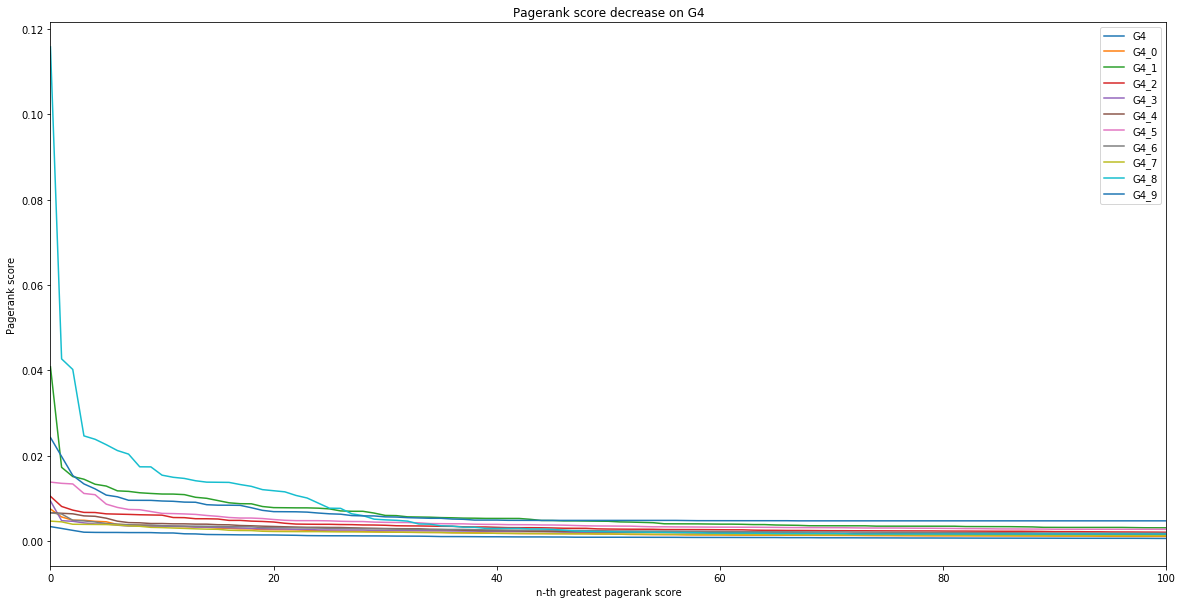

In [282]:
## Pagerank score decrease for G4

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

## Plot for G4

list_value_bis = sorted([G4_PR[key] for key in G4_PR.keys()], reverse = True)
list_x = np.arange(0,len(G4_PR),1)

ax.plot(list_x, list_value_bis, label = 'G4')

##Plot for G4 communities
for i in range(len(G4_PR_com)):
    vars()['list_value{}'.format(i)] = sorted([G4_PR_com[i][key] for key in G4_PR_com[i].keys()], reverse = True)
    vars()['list_x{}'.format(i)] = np.arange(0,len(G4_PR_com[i]),1)

for i in range(len(G4_PR_com)):
    ax.plot(vars()['list_x{}'.format(i)], vars()['list_value{}'.format(i)], label = 'G4_{}'.format(i))


ax.legend()
ax.set_xlim(0,100)
ax.set_title('Pagerank score decrease on G4')
ax.set_xlabel('n-th greatest pagerank score')
ax.set_ylabel('Pagerank score')
plt.show()

Looking at how the pagerank score decreases in G4, we can say that one Youtuber has a score greater than all others but not by much (blue line starting from around 0.03). However in two communities (G4_1 and G4_8), we can clearly see that one Youtuber has greater scores than all the others whereas in the other communities, the score does not decrease too sharply.

The pagerank can be understood as follow: a high score means that if a user is subscribed to a Youtuber in the community, there is a high chance that the user is also subscribed to the maximum pagerank score Youtuber. If we consider that the data are unbiased, we might extrapolate that it is the Youtubers with the most subscribers in their community. 

Several communities and Youtube overall seems not to have a clear leader, potentially because of communities that are evolving independently from each other. It is to say, considering that many communities had time to grow (or the community itself is big enough), there would be Youtubers of great importance in their respective community but equally important for Youtube. 

## Conclusion

Youtube does not have a clear power law behavior concerning weighted degree distribution. One might say that Youtube is not a social network like network and that would be logic as Youtube can be viewed as a bipartite networks Youtubers/Youtube users. It would be interesting to only study the networks of Youtubers.

It is clear that Youtube an be decomposed into communities. Louvain algorithm found some communities for our data but one may consider repeating the community detection process with other algorithms, maybe with algorithms developed in [1]. However there are nothe same number of communities detected in G3 and G4 so as said previously, it would be interesting to investigate relations between communities in G3 particularly.

Finally, Youtube does not seem to have a clear leader but rather a bunch of leaders. It is not always true in communities but maybe results are biased because of the size of a community. Further investigations might be needed.

This work was far from being exhaustive but show an insight of Youtube network structure. It would really be interesting to work on data showing directed edges of subscription (and not numbers of shared something) in the future to maybe reveal the (almost) bipartite structure of Youtube compute communities and other values that are easier to interpret.

## References

[1] Lei Tang, Xufei Wang, and Huan Liu. "Uncovering Groups via Heterogeneous Interaction Analysis", IEEE International Conference on Data Mining (ICDM09), Dec. 6-9, 2009. Miami Florida.